In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import f1_score

SEED = 42

In [2]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder

def preprocess_data(dataframe, encoding='one-hot'):
    df = dataframe.copy()
    mean_age = int(df[df['is_victim_age_missing'] == False]['Victim Age'].mean())
    df.loc[df['is_victim_age_missing'], 'Victim Age'] = mean_age
    df.drop(columns='is_victim_age_missing', inplace=True)
    y = df['Crime Solved'].apply(lambda x: 1 if x == 'No' else 0)
    df.drop(columns='Crime Solved', inplace=True)
    
    non_cat_features = ['Perpetrator Count', 'Victim Age', 'Victim Count']
    cat_features = list(set(df.columns) - set(non_cat_features))
    
    if encoding == 'one-hot':
        enc_cat = OneHotEncoder().fit_transform(df[cat_features]).toarray()
    elif encoding == 'ordinal':
        enc_cat = OrdinalEncoder().fit_transform(df[cat_features])

    enc_X = np.concatenate((enc_cat, df[non_cat_features]), axis=1)
    
    return enc_X, y

In [3]:
df = pd.read_csv('data_2014.csv')

**Предобработка данных - кодирование категориальных признаков**

Категориальные признаки можно кодировать как One-hot вектора, либо кодировать натуральным числом (Ordinal encoding), упорядочивая некоторым образом значения признаков.

Так как в данной задаче у значений признаков нет порядка, то применять Ordinal encoding мы не будем, поскольку это может отрицательно сказаться на линейных моделях (куда входит и svm).

In [4]:
X, y = preprocess_data(df)

**Подбор гиперпараметров**

In [5]:
def get_best_estimator(params, X, y, print_=True):
    grid_search = GridSearchCV(SVC(random_state=SEED), params, scoring=['f1', 'precision', 'recall'], 
                               refit='f1', cv=5, n_jobs=-1, verbose=3)
    grid_search.fit(X, y)

    if print_:
        print('Best params of grid search: ', grid_search.best_params_)
        index = grid_search.best_index_
        results = grid_search.cv_results_
        for metric in ['f1', 'precision', 'recall']:
            print(metric, '=', results[f'mean_test_{metric}'][index], '±', results[f'std_test_{metric}'][index])
            
    return grid_search.best_estimator_

Поскольку для полиномиального ядра при некоторых гиперпараметрах обучение происходило очень долго, а прироста качества не было, то из сетки параметров пришлось полиномиальное ядро пришлось убрать вовсе.

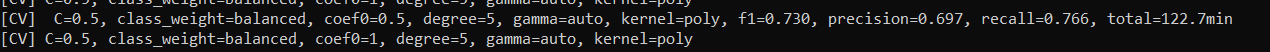

In [ ]:
params = {
    'C': [0.1, 0.5, 1, 5],
    'kernel': ['linear', 'rbf', 'sigmoid'],
    'gamma': ['scale', 'auto', 1, 5],
    'class_weight': ['balanced', None],
    'coef0': [0, 1, 5]
}

In [ ]:
best_svm = get_best_estimator(params, X, y)

Fitting 5 folds for each of 288 candidates, totalling 1440 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   43.5s
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed: 12.1min
[Parallel(n_jobs=-1)]: Done 488 tasks      | elapsed: 22.0min
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed: 34.5min
[Parallel(n_jobs=-1)]: Done 1128 tasks      | elapsed: 50.3min
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed: 65.7min finished


Best params of grid search:  {'C': 0.1, 'class_weight': None, 'coef0': 0, 'gamma': 'scale', 'kernel': 'linear'}
f1 = 0.7351118730671619 ± 0.0070851210784109
precision = 0.7032649535987657 ± 0.005563472325392974
recall = 0.7702574460323591 ± 0.016960582667482876


In [6]:
import joblib

joblib.dump(best_svm, '1_svm_clf.joblib')
# best_svm = joblib.load('1_svm_clf.joblib')

**Время обучения модели с оптимальными гиперпараметрами**

In [8]:
import time

N_RUNS = 31
ticks = []
for i in range(N_RUNS):
    start = time.time()
    best_svm.fit(X, y)
    stop = time.time()
    ticks.append((start, stop))

In [9]:
fit_times = np.array([stop - start for start, stop in ticks])[1:]
print('Mean fit time:', fit_times.mean())
print('Standard deviation:', fit_times.std(ddof=1))

Mean fit time: 16.41548660596212
Standard deviation: 0.4984726985128031


**Время вычисления предсказания модели с оптимальными гиперпараметрами для одного объекта**

In [10]:
ticks = []
for i, x in enumerate(X):
    x = x[np.newaxis, :]
    start = time.time()
    best_svm.predict(x)
    stop = time.time()
    ticks.append((start, stop))

In [11]:
predict_times = np.array([stop - start for start, stop in ticks])[1:]
print('Mean predict time:', predict_times.mean())
print('Standard deviation:', predict_times.std(ddof=1))

Mean predict time: 0.001353273656786558
Standard deviation: 0.00010094701862708233


**Характеристики используемых ресурсов** (для последних измерений использовался google colab)

In [12]:
! cat /proc/cpuinfo

processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 79
model name	: Intel(R) Xeon(R) CPU @ 2.20GHz
stepping	: 0
microcode	: 0x1
cpu MHz		: 2200.000
cache size	: 56320 KB
physical id	: 0
siblings	: 2
core id		: 0
cpu cores	: 1
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm 3dnowprefetch invpcid_single ssbd ibrs ibpb stibp fsgsbase tsc_adjust bmi1 hle avx2 smep bmi2 erms invpcid rtm rdseed adx smap xsaveopt arat md_clear arch_capabilities
bugs		: cpu_meltdown spectre_v1 spectre_v2 spec_store_bypass l1tf mds swapgs taa
bogomips	: 4400.00
clflush size	: 64
cache_alignment	: 64
address sizes	: 46 bits physical, 48 b